## Phân tích 1 cái điểm số thì đến từ những log nào

In [10]:
import pandas as pd

# 1. Load Data
grades = pd.read_csv('../data/data_670/udk_moodle_grades_course_670.csv') # File điểm của bạn
logs = pd.read_csv('../data/data_670/udk_moodle_log_course_670.csv')     # File log của bạn

# 2. Chuẩn hóa thời gian Log về Unix Timestamp (để so sánh được với Grade)
# Convert string '2022-09-03 13:04:58' -> Unix Timestamp
logs['timestamp'] = pd.to_datetime(logs['timecreated']).astype(int) // 10**9

# 3. Hàm tìm Logs dẫn tới điểm số (Đơn giản nhất)
def find_triggering_logs(grade_row):
    # Nếu là điểm tổng kết khóa học (course), thường không do log đơn lẻ nào sinh ra -> Bỏ qua hoặc lấy log cuối cùng
    # Ở đây ta tập trung vào điểm thành phần (mod)
    
    # BƯỚC 1: LỌC
    # Lấy các log thỏa mãn 3 điều kiện:
    # 1. Đúng User đó
    # 2. Đúng Course đó
    # 3. Thời gian Log phải xảy ra TRƯỚC hoặc BẰNG thời gian có điểm
    relevant_logs = logs[
        (logs['userid'] == grade_row['userid']) & 
        (logs['courseid'] == grade_row['courseid']) & 
        (logs['timestamp'] <= grade_row['timemodified'])
    ]
    
    if relevant_logs.empty:
        return []
    
    # BƯỚC 2: SẮP XẾP & LẤY MẪU
    # Sắp xếp từ mới nhất đến cũ nhất. 
    # Lấy 3 log gần nhất. Đây thường là các hành động: View -> Upload -> Submit
    top_logs = relevant_logs.sort_values('timestamp', ascending=False).head(3)
    
    # Trả về dạng list các dictionary để dễ nhìn
    result = []
    for _, log in top_logs.iterrows():
        result.append(f"{log['eventname']} (ID: {log['id']} - Time: {log['timecreated']})")
        
    return result

# 4. Áp dụng vào bảng Grade
# Chỉ áp dụng cho các dòng có item type là 'mod' (điểm bài tập) để đỡ rối
grades_mod = grades[grades['itemtype'] == 'mod'].copy()
grades_mod['causing_logs'] = grades_mod.apply(find_triggering_logs, axis=1)

# 5. In kết quả
# In ra User, Điểm, và Các log dẫn tới điểm đó
pd.set_option('display.max_colwidth', None) # Để hiển thị hết nội dung log
result_df = grades_mod[['userid', 'finalgrade', 'causing_logs']]
print(result_df)

# 6. Lưu vào file
output_path = '../data/data_670/data_output/grades_with_logs.csv'
result_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"\n✓ Đã lưu kết quả vào: {output_path}")

     userid  finalgrade  \
19     8860           5   
20     9227           9   
21     9227           8   
22     9227           9   
23     9183           8   
..      ...         ...   
227    9152          10   
228    9169          10   
229    9169           9   
230    8860          10   
231    9220          10   

                                                                                                                                                                                                                                                               causing_logs  
19   [\mod_assign\event\submission_status_viewed (ID: 11059212 - Time: 2023-01-23 19:23:10), \assignsubmission_file\event\submission_created (ID: 11059208 - Time: 2023-01-23 19:23:10), \mod_assign\event\course_module_viewed (ID: 11059204 - Time: 2023-01-23 19:23:10)]  
20                    [\gradereport_user\event\grade_report_viewed (ID: 11056994 - Time: 2023-01-23 17:25:19), \core\event\course_viewe

In [11]:

# 7. Phân tích Hành vi học tập (Behavior Analysis)
def analyze_behavior(grade_row):
    # 1. Tìm logs trong quá khứ
    relevant_logs = logs[
        (logs['userid'] == grade_row['userid']) & 
        (logs['courseid'] == grade_row['courseid']) & 
        (logs['timestamp'] <= grade_row['timemodified'])
    ]
    
    if relevant_logs.empty:
        return "No_Activity"

    # 2. Định nghĩa bộ lọc "Hành động mạnh" (Strong Actions)
    strong_actions = ['submitted', 'uploaded', 'created', 'attempt_started']
    
    # Lọc lấy các log quan trọng
    # Cách check: xem từ khóa có nằm trong eventname không
    action_logs = relevant_logs[relevant_logs['eventname'].str.contains('|'.join(strong_actions), case=False, na=False)]
    
    # 3. Logic phân loại
    if action_logs.empty:
        # Nếu không có hành động nộp bài, kiểm tra xem có xem tài liệu không
        return "Passive_View_Only" # Chỉ xem, không làm
    
    # Lấy hành động mạnh gần nhất
    last_action = action_logs.sort_values('timestamp', ascending=False).iloc[0]
    
    # 4. Tính độ trễ (Time Lag) - Đơn vị: Giờ
    time_diff_hours = (grade_row['timemodified'] - last_action['timestamp']) / 3600
    
    if time_diff_hours > 336: # > 2 tuần
        return f"Old_Activity_Found ({int(time_diff_hours/24)} days ago)" # Cảnh báo dữ liệu cũ (như User 8860)
        
    return f"Active_Submission (Lag: {round(time_diff_hours, 2)}h) - {last_action['eventname']}"

# Áp dụng
grades['behavior_analysis'] = grades.apply(analyze_behavior, axis=1)
print("\n=== PHÂN TÍCH HÀNH VI HỌC TẬP ===\n")
print(grades[['userid', 'finalgrade', 'behavior_analysis']])

# Lưu kết quả chi tiết
behavior_output_path = '../data/data_670/data_output/behavior_analysis_results.csv'
grades[['userid', 'finalgrade', 'behavior_analysis']].to_csv(behavior_output_path, index=False, encoding='utf-8')
print(f"\n✓ Đã lưu phân tích hành vi vào: {behavior_output_path}")

# Thống kê
print("\n=== THỐNG KÊ HÀNH VI ===")
behavior_stats = grades['behavior_analysis'].value_counts()
print(behavior_stats)



=== PHÂN TÍCH HÀNH VI HỌC TẬP ===

     userid  finalgrade  \
0      8860           6   
1      9227          -1   
2      8609           9   
3      9169           8   
4      9043           7   
..      ...         ...   
228    9169          10   
229    9169           9   
230    8860          10   
231    9220          10   
232    8671          -1   

                                                            behavior_analysis  
0    Active_Submission (Lag: 18.25h) - \mod_assign\event\assessable_submitted  
1     Active_Submission (Lag: 37.9h) - \mod_assign\event\assessable_submitted  
2        Active_Submission (Lag: 173.22h) - \mod_quiz\event\attempt_submitted  
3        Active_Submission (Lag: 172.43h) - \mod_quiz\event\attempt_submitted  
4        Active_Submission (Lag: 172.98h) - \mod_quiz\event\attempt_submitted  
..                                                                        ...  
228                                          Old_Activity_Found (35 days ago)  

In [12]:

# ==========================================
# 8. PHÂN TÍCH KHOẢNG CHỜ ĐIỂM (GAP ANALYSIS)
# ==========================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.lines import Line2D

def analyze_gap_activities(grade_row):
    # Lấy toàn bộ log của user trong course đó xảy ra trước khi có điểm
    candidate_logs = logs[
        (logs['userid'] == grade_row['userid']) & 
        (logs['courseid'] == grade_row['courseid']) & 
        (logs['timestamp'] <= grade_row['timemodified'])
    ]
    
    if candidate_logs.empty:
        return None

    # Tìm "Strong Action" gần nhất để làm mốc BẮT ĐẦU (T_submit)
    strong_actions = ['submitted', 'uploaded', 'created', 'attempt_submitted']
    submission_logs = candidate_logs[candidate_logs['eventname'].str.contains('|'.join(strong_actions), case=False, na=False)]
    
    if submission_logs.empty:
        return None # Không tìm thấy hành động nộp bài nào
        
    # Lấy log nộp bài gần nhất
    submission_log = submission_logs.sort_values('timestamp', ascending=False).iloc[0]
    t_submit = submission_log['timestamp']
    t_grade = grade_row['timemodified']
    
    # Nếu thời gian nộp và chấm trùng nhau (Auto-grade) -> Gap = 0
    if t_grade - t_submit < 60: 
        return {
            'status': 'Auto-Graded (Instant)',
            'gap_duration_hours': 0,
            'activities': [],
            't_submit': t_submit,
            't_grade': t_grade
        }

    # Lấy các log NẰM GIỮA t_submit và t_grade
    # Đây chính là "Hành động trong lúc chờ điểm"
    gap_logs = candidate_logs[candidate_logs['timestamp'] > t_submit].sort_values('timestamp')
    
    # Tổng hợp hành động cho gọn
    activities_summary = []
    for _, log in gap_logs.iterrows():
        event = log['eventname']
        # Đơn giản hóa tên event để vẽ biểu đồ cho đẹp
        if 'grade' in event: label = 'Check Grade'
        elif 'course_viewed' in event: label = 'View Course'
        elif 'module_viewed' in event: label = 'View Module'
        elif 'user_loggedin' in event: label = 'Login'
        else: label = 'Other'
        
        activities_summary.append({
            'timestamp': log['timestamp'],
            'action': label,
            'original_event': event
        })
        
    return {
        'status': 'Waiting for Grade',
        'gap_duration_hours': round((t_grade - t_submit) / 3600, 2),
        'activities': activities_summary, # List các hành động chi tiết
        'activity_count': len(activities_summary),
        't_submit': t_submit,
        't_grade': t_grade
    }

# Áp dụng hàm
gap_data = grades_mod.apply(analyze_gap_activities, axis=1)
grades_mod['gap_analysis'] = gap_data

# Lọc bỏ các dòng None (không tìm thấy log nộp bài)
df_viz = grades_mod.dropna(subset=['gap_analysis'])

print("\n=== THỐNG KÊ KHOẢNG CHỜ ĐIỂM ===")
print(f"Tổng số bài nộp phân tích được: {len(df_viz)}")

# Thống kê gap duration
gap_durations = [d['gap_duration_hours'] for d in df_viz['gap_analysis'] if d]
print(f"Thời gian chờ trung bình: {sum(gap_durations)/len(gap_durations):.2f} giờ")
print(f"Thời gian chờ ngắn nhất: {min(gap_durations):.2f} giờ")
print(f"Thời gian chờ dài nhất: {max(gap_durations):.2f} giờ")

# Lưu kết quả gap analysis
gap_results = []
for idx, row in df_viz.iterrows():
    data = row['gap_analysis']
    gap_results.append({
        'userid': row['userid'],
        'finalgrade': row['finalgrade'],
        'status': data['status'],
        'gap_duration_hours': data['gap_duration_hours'],
        'activity_count': data['activity_count'] if 'activity_count' in data else 0
    })

gap_df = pd.DataFrame(gap_results)
gap_output_path = '../data/data_670/data_output/gap_analysis_results.csv'
gap_df.to_csv(gap_output_path, index=False, encoding='utf-8')
print(f"\n✓ Đã lưu phân tích khoảng chờ vào: {gap_output_path}")



=== THỐNG KÊ KHOẢNG CHỜ ĐIỂM ===
Tổng số bài nộp phân tích được: 211
Thời gian chờ trung bình: 511.17 giờ
Thời gian chờ ngắn nhất: 0.33 giờ
Thời gian chờ dài nhất: 1580.06 giờ

✓ Đã lưu phân tích khoảng chờ vào: ../data/data_670/data_output/gap_analysis_results.csv



✓ Đã lưu biểu đồ tổng hợp vào: ../data/data_670/data_output/gap_analysis_comprehensive.png


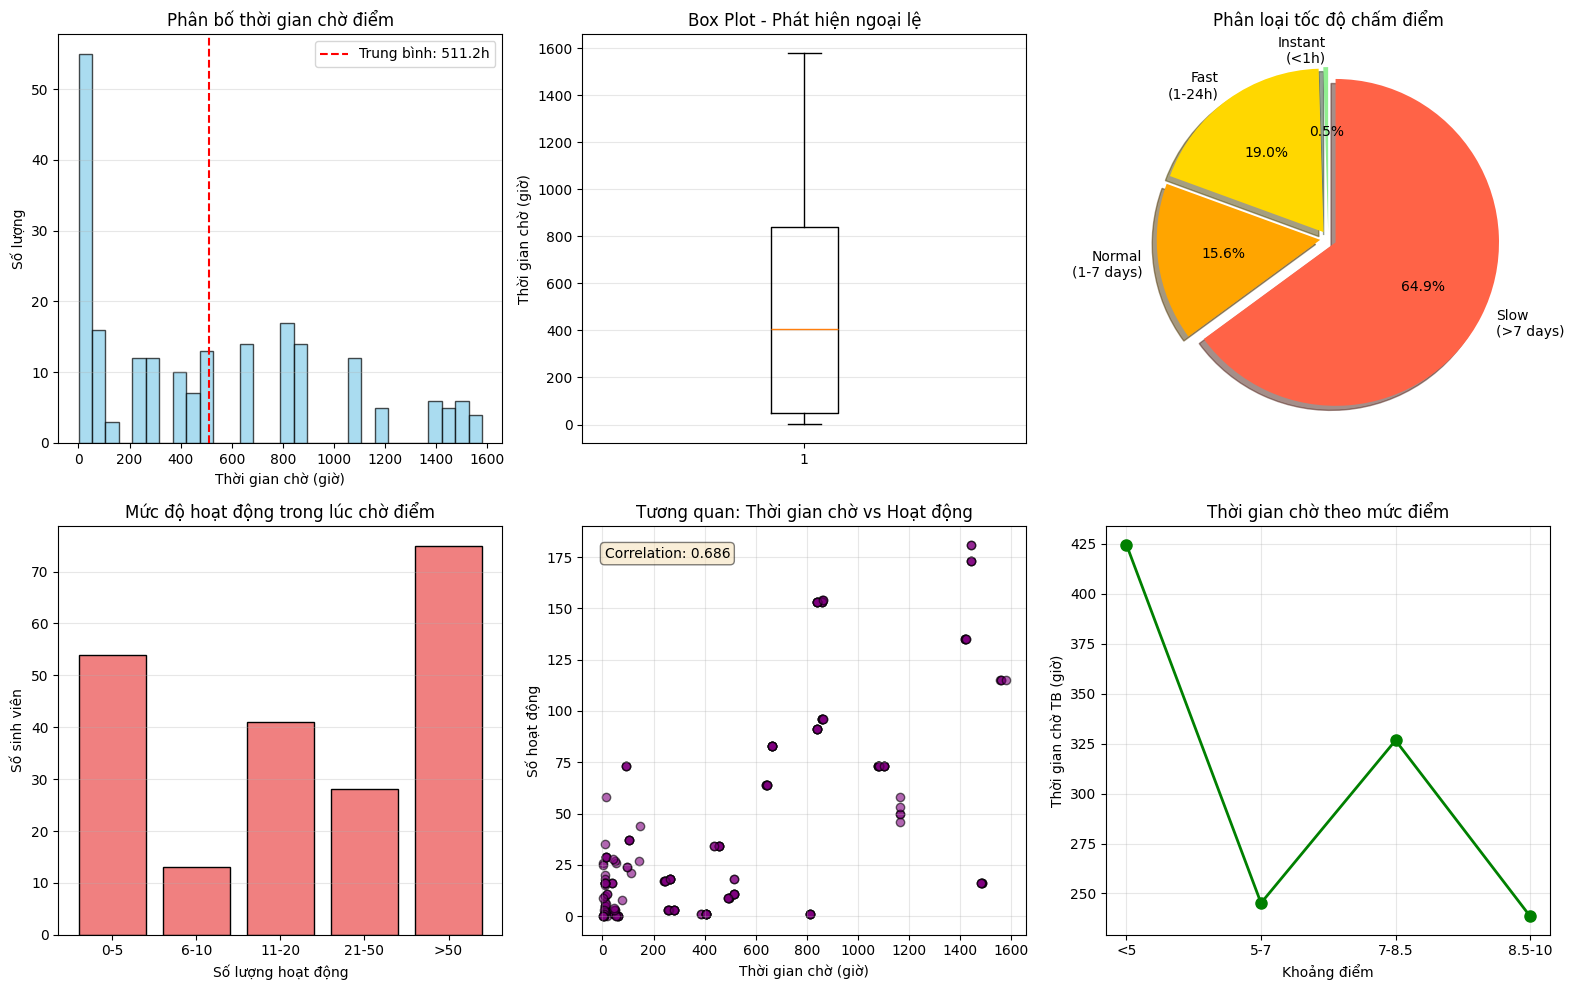


=== PHÂN TÍCH CHI TIẾT ===
- Instant grading (<1h): 1 bài (0.5%)
- Fast grading (1-24h): 40 bài (19.0%)
- Normal grading (1-7 days): 33 bài (15.6%)
- Slow grading (>7 days): 137 bài (64.9%)

Số hoạt động trung bình trong lúc chờ: 44.75
Correlation (thời gian chờ vs hoạt động): 0.686


In [14]:

# ==========================================
# 8.1. BIỂU ĐỒ PHÂN TÍCH GAP
# ==========================================

# Tạo figure với nhiều subplot
fig = plt.figure(figsize=(16, 10))

# 1. Histogram - Phân bố thời gian chờ
ax1 = plt.subplot(2, 3, 1)
plt.hist(gap_durations, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Thời gian chờ (giờ)')
plt.ylabel('Số lượng')
plt.title('Phân bố thời gian chờ điểm')
plt.axvline(sum(gap_durations)/len(gap_durations), color='red', linestyle='--', label=f'Trung bình: {sum(gap_durations)/len(gap_durations):.1f}h')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# 2. Box Plot - Phân tích outliers
ax2 = plt.subplot(2, 3, 2)
plt.boxplot(gap_durations, vert=True)
plt.ylabel('Thời gian chờ (giờ)')
plt.title('Box Plot - Phát hiện ngoại lệ')
plt.grid(axis='y', alpha=0.3)

# 3. Pie Chart - Phân loại thời gian chờ
ax3 = plt.subplot(2, 3, 3)
# Phân loại: Instant (<1h), Fast (<24h), Normal (1-7 days), Slow (>7 days)
instant = sum(1 for d in gap_durations if d < 1)
fast = sum(1 for d in gap_durations if 1 <= d < 24)
normal = sum(1 for d in gap_durations if 24 <= d < 168)
slow = sum(1 for d in gap_durations if d >= 168)

categories = ['Instant\n(<1h)', 'Fast\n(1-24h)', 'Normal\n(1-7 days)', 'Slow\n(>7 days)']
sizes = [instant, fast, normal, slow]
colors = ['#90EE90', '#FFD700', '#FFA500', '#FF6347']
explode = (0.05, 0.05, 0.05, 0.05)

plt.pie(sizes, explode=explode, labels=categories, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Phân loại tốc độ chấm điểm')

# 4. Bar Chart - Số lượng hoạt động trong lúc chờ
ax4 = plt.subplot(2, 3, 4)
activity_counts = [d['activity_count'] if 'activity_count' in d else 0 for d in df_viz['gap_analysis']]
bins_activity = [0, 5, 10, 20, 50, max(activity_counts)+1]
labels_activity = ['0-5', '6-10', '11-20', '21-50', '>50']
activity_distribution = []
for i in range(len(bins_activity)-1):
    count = sum(1 for a in activity_counts if bins_activity[i] <= a < bins_activity[i+1])
    activity_distribution.append(count)

plt.bar(labels_activity, activity_distribution, color='lightcoral', edgecolor='black')
plt.xlabel('Số lượng hoạt động')
plt.ylabel('Số sinh viên')
plt.title('Mức độ hoạt động trong lúc chờ điểm')
plt.grid(axis='y', alpha=0.3)

# 5. Scatter Plot - Mối quan hệ giữa thời gian chờ và số hoạt động
ax5 = plt.subplot(2, 3, 5)
plt.scatter(gap_durations, activity_counts, alpha=0.6, c='purple', edgecolors='black')
plt.xlabel('Thời gian chờ (giờ)')
plt.ylabel('Số hoạt động')
plt.title('Tương quan: Thời gian chờ vs Hoạt động')
plt.grid(alpha=0.3)

# Thêm correlation coefficient
if len(gap_durations) > 1:
    correlation = pd.Series(gap_durations).corr(pd.Series(activity_counts))
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax5.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Line Chart - Xu hướng theo điểm số
ax6 = plt.subplot(2, 3, 6)
# Nhóm theo khoảng điểm
grade_bins = [0, 5, 7, 8.5, 10]
grade_labels = ['<5', '5-7', '7-8.5', '8.5-10']
avg_gap_by_grade = []

for i in range(len(grade_bins)-1):
    grades_in_range = gap_df[(gap_df['finalgrade'] >= grade_bins[i]) & 
                             (gap_df['finalgrade'] < grade_bins[i+1])]
    if len(grades_in_range) > 0:
        avg_gap_by_grade.append(grades_in_range['gap_duration_hours'].mean())
    else:
        avg_gap_by_grade.append(0)

plt.plot(grade_labels, avg_gap_by_grade, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Khoảng điểm')
plt.ylabel('Thời gian chờ TB (giờ)')
plt.title('Thời gian chờ theo mức điểm')
plt.grid(alpha=0.3)

plt.tight_layout()

# Lưu biểu đồ tổng hợp
comprehensive_chart_path = '../data/data_670/data_output/gap_analysis_comprehensive.png'
plt.savefig(comprehensive_chart_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Đã lưu biểu đồ tổng hợp vào: {comprehensive_chart_path}")

plt.show()

# In thêm thống kê chi tiết
print("\n=== PHÂN TÍCH CHI TIẾT ===")
print(f"- Instant grading (<1h): {instant} bài ({instant/len(gap_durations)*100:.1f}%)")
print(f"- Fast grading (1-24h): {fast} bài ({fast/len(gap_durations)*100:.1f}%)")
print(f"- Normal grading (1-7 days): {normal} bài ({normal/len(gap_durations)*100:.1f}%)")
print(f"- Slow grading (>7 days): {slow} bài ({slow/len(gap_durations)*100:.1f}%)")
print(f"\nSố hoạt động trung bình trong lúc chờ: {sum(activity_counts)/len(activity_counts):.2f}")
print(f"Correlation (thời gian chờ vs hoạt động): {correlation:.3f}")


In [15]:

# ==========================================
# 10. Xuất toàn bộ log thô từ hành vi mạnh gần nhất tới khi có điểm (per user/per grade)
# ==========================================
from pathlib import Path

raw_logs_dir = Path('../data/data_670/data_output/raw_logs_by_user_grade')
raw_logs_dir.mkdir(parents=True, exist_ok=True)

raw_log_records = []
strong_actions_window = ['submitted', 'uploaded', 'created', 'attempt_submitted', 'attempt_started']

for idx, grade_row in grades_mod.iterrows():
    # Lấy tất cả log của user trong course trước hoặc bằng thời điểm có điểm
    candidate_logs = logs[
        (logs['userid'] == grade_row['userid']) &
        (logs['courseid'] == grade_row['courseid']) &
        (logs['timestamp'] <= grade_row['timemodified'])
    ]

    if candidate_logs.empty:
        continue

    # Tìm hành vi mạnh gần nhất
    strong_logs = candidate_logs[candidate_logs['eventname'].str.contains('|'.join(strong_actions_window), case=False, na=False)]
    if strong_logs.empty:
        continue

    last_strong = strong_logs.sort_values('timestamp', ascending=False).iloc[0]
    t_start = last_strong['timestamp']
    t_end = grade_row['timemodified']

    # Lọc log từ hành vi mạnh tới thời điểm có điểm
    window_logs = candidate_logs[(candidate_logs['timestamp'] >= t_start) & (candidate_logs['timestamp'] <= t_end)]
    window_logs = window_logs.sort_values('timestamp')

    # Xác định tên file
    item_id = grade_row['itemid'] if 'itemid' in grade_row else idx
    filename = f"user_{grade_row['userid']}_item_{item_id}_grade_{int(t_end)}.csv"
    file_path = raw_logs_dir / filename

    # Lưu file
    window_logs.to_csv(file_path, index=False, encoding='utf-8')

    raw_log_records.append({
        'userid': grade_row['userid'],
        'itemid': item_id,
        'finalgrade': grade_row.get('finalgrade', None),
        't_start': t_start,
        't_grade': t_end,
        'strong_event': last_strong['eventname'],
        'log_count': len(window_logs),
        'file': str(file_path)
    })

# Lưu chỉ mục tổng hợp
raw_index_path = raw_logs_dir / 'raw_logs_index.csv'
pd.DataFrame(raw_log_records).to_csv(raw_index_path, index=False, encoding='utf-8')

print(f"\n✓ Đã lưu {len(raw_log_records)} file log thô vào thư mục: {raw_logs_dir}")
print(f"✓ File chỉ mục: {raw_index_path}")



✓ Đã lưu 211 file log thô vào thư mục: ../data/data_670/data_output/raw_logs_by_user_grade
✓ File chỉ mục: ../data/data_670/data_output/raw_logs_by_user_grade/raw_logs_index.csv



✓ Đã lưu biểu đồ vào: ../data/data_670/data_output/gap_timeline_visualization.png


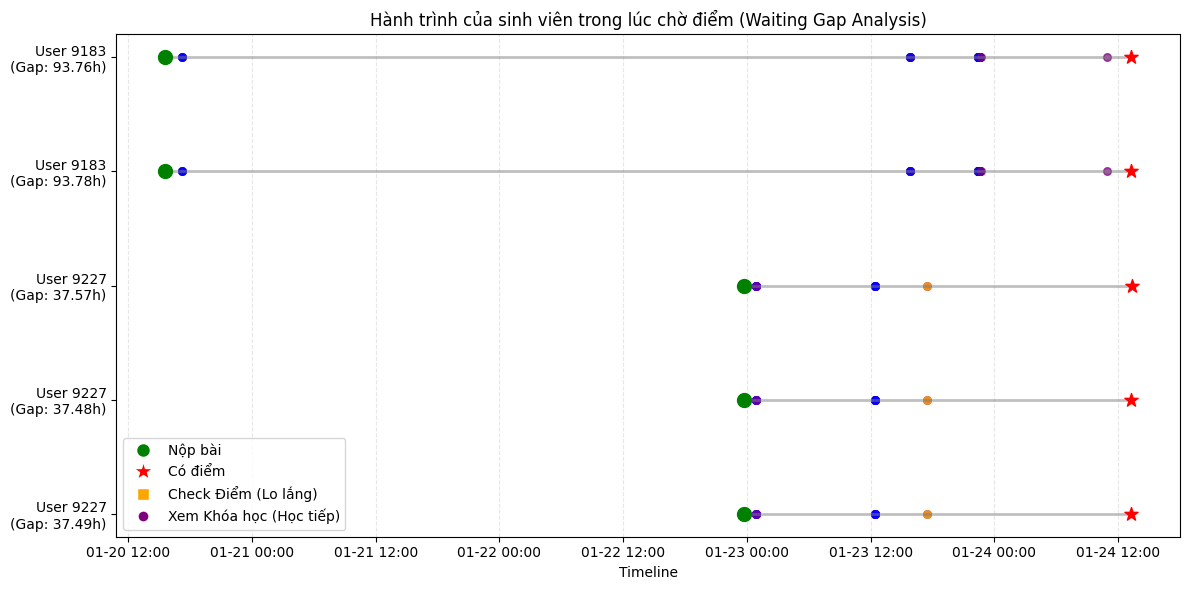

In [13]:

# ==========================================
# 9. VẼ BIỂU ĐỒ TIMELINE (VISUALIZATION)
# ==========================================
# Chọn ra 5 mẫu tiêu biểu có hành động trong lúc chờ (Gap > 0 và có Activity)
sample_users = []
for idx, row in df_viz.iterrows():
    data = row['gap_analysis']
    if data['gap_duration_hours'] > 0 and len(data['activities']) > 0:
        sample_users.append((row['userid'], data))
    if len(sample_users) >= 5: break

if len(sample_users) > 0:
    # Vẽ biểu đồ Timeline
    fig, ax = plt.subplots(figsize=(12, 6))

    y_labels = []
    for i, (uid, data) in enumerate(sample_users):
        # 1. Vẽ đường ngang (Khoảng thời gian chờ)
        start_date = pd.to_datetime(data['t_submit'], unit='s')
        end_date = pd.to_datetime(data['t_grade'], unit='s')
        
        ax.hlines(y=i, xmin=start_date, xmax=end_date, color='gray', alpha=0.5, linewidth=2)
        
        # 2. Đánh dấu điểm Bắt đầu (Nộp bài) và Kết thúc (Có điểm)
        ax.scatter(start_date, i, color='green', s=100, label='Submitted' if i == 0 else "", zorder=3)
        ax.scatter(end_date, i, color='red', s=100, marker='*', label='Graded' if i == 0 else "", zorder=3)
        
        # 3. Vẽ các hành động trung gian (Intermediate Actions)
        for act in data['activities']:
            act_time = pd.to_datetime(act['timestamp'], unit='s')
            marker = 'o'
            color = 'blue'
            
            # Đổi màu theo loại hành động
            if act['action'] == 'Check Grade': color = 'orange'; marker='s' # Checking
            elif act['action'] == 'View Course': color = 'purple' # Learning
            
            ax.scatter(act_time, i, color=color, s=30, alpha=0.7)

        y_labels.append(f"User {uid}\n(Gap: {data['gap_duration_hours']}h)")

    # Trang trí biểu đồ
    ax.set_yticks(range(len(sample_users)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Timeline")
    ax.set_title("Hành trình của sinh viên trong lúc chờ điểm (Waiting Gap Analysis)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.grid(axis='x', linestyle='--', alpha=0.3)

    # Tạo chú thích tay (Manual Legend) cho các chấm nhỏ
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Nộp bài', markersize=10),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='red', label='Có điểm', markersize=15),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', label='Check Điểm (Lo lắng)', markersize=8),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', label='Xem Khóa học (Học tiếp)', markersize=8),
    ]
    ax.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    
    # Lưu biểu đồ
    chart_path = '../data/data_670/data_output/gap_timeline_visualization.png'
    plt.savefig(chart_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Đã lưu biểu đồ vào: {chart_path}")
    
    plt.show()
else:
    print("\n⚠ Không tìm thấy mẫu dữ liệu phù hợp để vẽ biểu đồ (cần có gap > 0 và có activities)")
